In [1]:
from adspredictor.trainer.trainer import *
import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('comparison_rough-fine_filtered.pkl')
df = df.loc[:, ['np', 'adsconf', 'atoms_fine']]
df

,np,adsconf,atoms_fine
0,MS,Ag_09,"(Atom('Cu', [np.float64(12.29521), np.float64(..."
1,MS,Ag_07,"(Atom('Cu', [np.float64(12.31017), np.float64(..."
2,MS,Ag_01,"(Atom('Cu', [np.float64(12.31917), np.float64(..."
3,MS,Ag_06,"(Atom('Cu', [np.float64(12.28306), np.float64(..."
4,MS,Ag_08,"(Atom('Cu', [np.float64(12.27612), np.float64(..."
...,...,...,...
322,34152,Cu_03,"(Atom('Cu', [np.float64(12.28599), np.float64(..."
324,34152,Pd_01,"(Atom('Cu', [np.float64(12.29058), np.float64(..."
325,34152,Au_02,"(Atom('Cu', [np.float64(12.28171), np.float64(..."
326,34152,Pd_06,"(Atom('Cu', [np.float64(12.29228), np.float64(..."


In [3]:
ref = {'AS': -171.092, 'LS': -170.383, 'MS': -172.001, 
       '23154': -171.081, '31245': -171.070, '34152': -171.076, '43125': -171.113,
       'LSminus1': -170.513}
CO_g = -14.424

# rename column atoms_fine to Atoms
df = df.rename(columns={'atoms_fine': 'Atoms'})

# Extract energy from atoms object
df['energy'] = df.Atoms.apply(lambda x: x.get_potential_energy())

# Calculate the adsorption energy
df['AdsE'] = df.apply(lambda x: x.energy - ref[x.np] - CO_g, axis=1)
df

,np,adsconf,Atoms,energy,AdsE
0,MS,Ag_09,"(Atom('Cu', [np.float64(12.29521), np.float64(...",-186.709519,-0.284519
1,MS,Ag_07,"(Atom('Cu', [np.float64(12.31017), np.float64(...",-186.632544,-0.207544
2,MS,Ag_01,"(Atom('Cu', [np.float64(12.31917), np.float64(...",-186.926266,-0.501266
3,MS,Ag_06,"(Atom('Cu', [np.float64(12.28306), np.float64(...",-186.684826,-0.259826
4,MS,Ag_08,"(Atom('Cu', [np.float64(12.27612), np.float64(...",-186.620595,-0.195595
...,...,...,...,...,...
322,34152,Cu_03,"(Atom('Cu', [np.float64(12.28599), np.float64(...",-186.393247,-0.893247
324,34152,Pd_01,"(Atom('Cu', [np.float64(12.29058), np.float64(...",-186.909588,-1.409588
325,34152,Au_02,"(Atom('Cu', [np.float64(12.28171), np.float64(...",-186.546506,-1.046506
326,34152,Pd_06,"(Atom('Cu', [np.float64(12.29228), np.float64(...",-186.816142,-1.316142


In [4]:
from adspredictor.featurizer.featurizer import FeatureCreator

fc = FeatureCreator(df, ads=55, listmetals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'])
cutoffs = [2.5, 4.62672286, 5.22347908, 6.33086662]    # Optimized cutoffs w/ 5th cutoff, the 5th was the same as the 4th

df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)
df.sample(5)

,np,adsconf,Atoms,energy,AdsE,R0_Ag,R0_Au,R0_Cu,R0_Pd,R0_Pt,...,R2_Ag,R2_Au,R2_Cu,R2_Pd,R2_Pt,R3_Ag,R3_Au,R3_Cu,R3_Pd,R3_Pt
87,31245,Pt_01,"(Atom('Cu', [np.float64(12.31101), np.float64(...",-187.483637,-1.989637,0,0,0,0,1,...,0,0,0,0,0,1,0,3,4,1
301,34152,Cu_06,"(Atom('Cu', [np.float64(12.29749), np.float64(...",-186.400623,-0.900623,0,0,1,0,0,...,0,0,0,0,0,3,2,0,0,2
142,43125,Au_06,"(Atom('Pd', [np.float64(12.23919), np.float64(...",-186.338017,-0.801017,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
133,43125,Au_07,"(Atom('Pd', [np.float64(12.21645), np.float64(...",-186.063871,-0.526871,0,1,0,0,0,...,0,0,0,0,0,1,1,0,3,2
228,AS,Ag_04,"(Atom('Pt', [np.float64(12.27788), np.float64(...",-185.943338,-0.427338,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [5]:
from sklearn.svm import SVR
from adspredictor.trainer.trainer import Trainer

features_to_use = []
for col in df.columns:
    if 'R' in col and '_' in col or 'AdsE' in col:
        features_to_use.append(col)

df_to_train = df.loc[:, features_to_use].copy()

# Initialize the trainer with the SVR model
trainer = Trainer(
    dataframe=df_to_train,
    target_column='AdsE',
    model=SVR,
    test_size=0.2,
    random_state=42,
    kernel='rbf',  # Additional model parameters
    C=1.0
    )

# Split the data and train the model
trainer.split_data()
trainer.train()

In [11]:
from prettytable import PrettyTable

# Evaluate the model
metrics = trainer.evaluate()
# Print the evaluation metrics in a nice table format

table = PrettyTable()
table.field_names = ["Metric", "Value"]

for key, value in metrics.items():
    if key == 'R2':
        table.add_row([key, f"{value:5.4f}"])
    else:
        table.add_row([key, f"{value:5.2f}"])

print(table)

+--------+--------+
| Metric | Value  |
+--------+--------+
|  MAE   |  0.17  |
|  RMSE  |  0.23  |
|   R2   | 0.8632 |
+--------+--------+


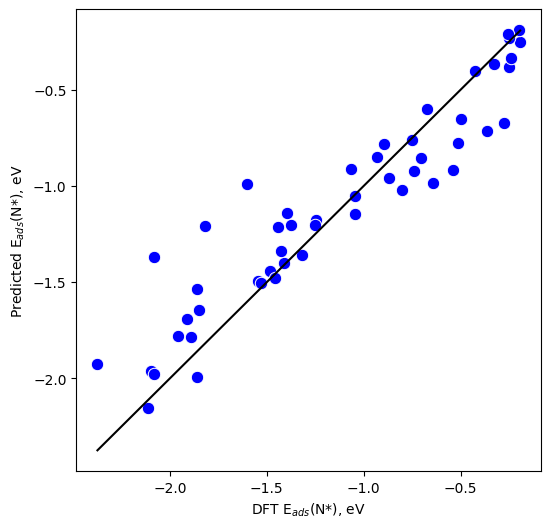

In [22]:
## Plot the parity plot

import matplotlib.pyplot as plt
import seaborn as sns

y_pred = trainer.model.predict(trainer.X_test)

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the parity plot
sns.scatterplot(x=trainer.y_test, y=y_pred, ax=ax, s=80, color='blue')
sns.lineplot(x=trainer.y_test, y=trainer.y_test, ax=ax, color='black')

# Set the labels
ax.set_xlabel(r'DFT E$_{ads}$(N*), eV')
ax.set_ylabel(r'Predicted E$_{ads}$(N*), eV')

plt.show()


CV_mae = 0.09366700906217525


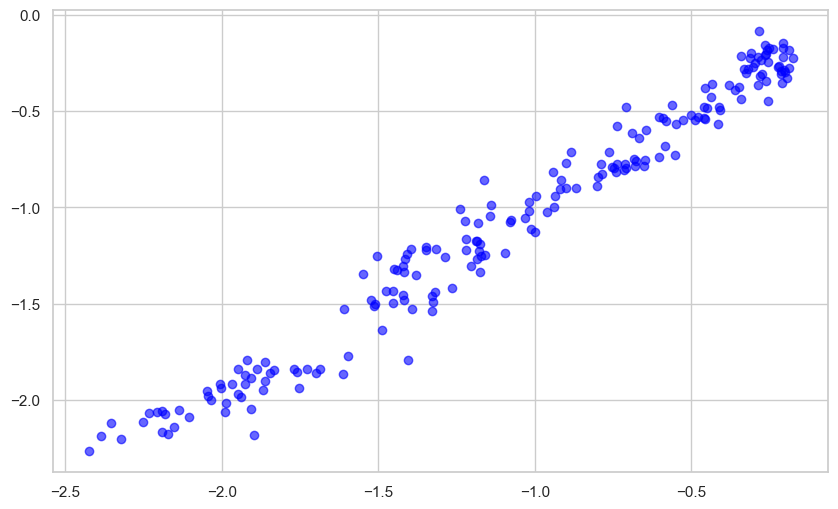

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

features_to_use = []
for col in df.columns:
    if 'R' in col and '_' in col or 'AdsE' in col:
        features_to_use.append(col)

X = df[features_to_use]
y = df['AdsE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
cv_mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print( 'CV_mae =',  - cv_mae_scores.mean()) 

# Plot the error
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
plt.scatter(y_train, model.predict(X_train), color='blue', alpha=0.6)

In [76]:
from sklearn import svm

def objective_function(cutoffs, model, df, response, features=None, test_size=0.1, random_state=42):

    fc = FeatureCreator(df, ads=55, listmetals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'])
    df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)
    features_to_use = extract_features(df, features)
    
    X = df[features_to_use]
    y = df[response]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    cv_mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    print(cutoffs, f'{- cv_mae_scores.mean():.4f}' )
    return cv_mae_scores.mean()

def extract_features(df, features):
    if features is None:
        feature_cols = df.columns()
    else:
        feature_cols = [col for col in df.columns if any(feature in col for feature in features)]
    return feature_cols

from scipy.optimize import minimize

#model = LinearRegression()
model = svm.SVR(kernel="poly", C=0.5, degree=2, epsilon=0.05, coef0=40)
features = ['R0_', 'R1_', 'R2_', 'R3_']
response = 'AdsE'
test_size = 0.2
random_state = 42

initial_guess = [2.5, 3.5, 4.1, 4.7]

# Constraints are that the cutoffs must be in ascending order
constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[2] - x[1]},
               {'type': 'ineq', 'fun': lambda x: x[3] - x[2]}]

# Bounds for the cutoffs. The max value is 10.0
bounds = [(1.5, 8.)] * len(initial_guess)

result = minimize(objective_function, initial_guess, tol=1e-6,
                  args=(model, df, response, features, test_size, random_state), method='SLSQP', jac='2-point',
                  bounds=bounds, constraints=constraints, options={'finite_diff_rel_step': 0.2, 'disp': True})
result

[2.5 3.5 4.1 4.7] 0.0997
[3.  3.5 4.1 4.7] 0.1069
[2.5 4.2 4.1 4.7] 0.1053
[2.5  3.5  4.92 4.7 ] 0.1082
[2.5  3.5  4.1  5.64] 0.0967
[2.51429562 3.50797494 4.11039021 4.69679542] 0.0995
[2.50467965 3.50261059 4.10340122 4.69895099] 0.1013
[3.00561558 3.50261059 4.10340122 4.69895099] 0.1068
[2.50467965 4.2031327  4.10340122 4.69895099] 0.1046
[2.50467965 3.50261059 4.92408146 4.69895099] 0.1087
[2.50467965 3.50261059 4.10340122 5.63874118] 0.0948
[2.54140395 3.51621688 4.13529978 4.6685368 ] 0.1000
[2.51239963 3.50547082 4.11010676 4.69255749] 0.1006
[2.50553372 3.50292702 4.10414306 4.69824367] 0.1033
[3.00664046 3.50292702 4.10414306 4.69824367] 0.1081
[2.50553372 4.20351242 4.10414306 4.69824367] 0.1048
[2.50553372 3.50292702 4.92497167 4.69824367] 0.1087
[2.50553372 3.50292702 4.10414306 5.6378924 ] 0.0948
[2.55553948 3.50718809 4.12765795 4.64727753] 0.1009
[2.51341551 3.50359864 4.10784942 4.6902105 ] 0.1010
[2.5063219  3.50299418 4.10451369 4.69744035] 0.1031
[2.50561254 3.50293

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.10327412807985607
       x: [ 2.506e+00  3.503e+00  4.104e+00  4.698e+00]
     nit: 3
     jac: [-9.723e-03 -2.242e-03 -6.561e-03  8.980e-03]
    nfev: 29
    njev: 3

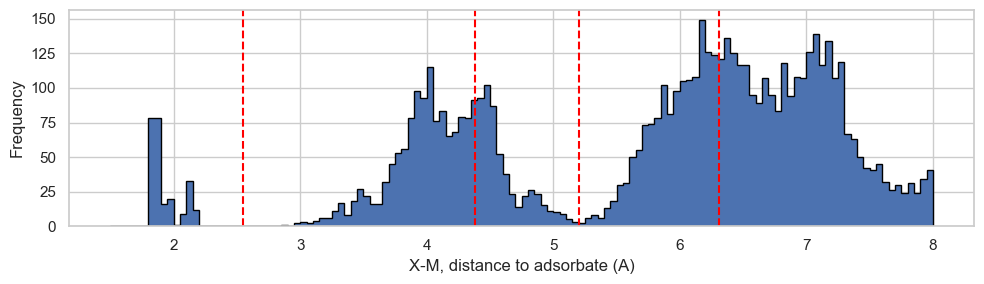

In [75]:
import numpy as np

fc = FeatureCreator(df, ads=55, listmetals=['Ag', 'Au', 'Cu', 'Pd', 'Pt'])
cutoffs = [2.55, 4.38, 5.20, 6.31]    # Optimized cutoffs w/ 5th cutoff, the 5th was the same as the 4th

df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)

list_distances = np.array([])
for atoms in fc.df.Atoms:
    d_matrix = atoms.get_all_distances()
    distances_X = d_matrix[55]
    # concat distances to list
    list_distances = np.concatenate([list_distances, distances_X])

# plot histogram of distances to CO
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 3))
plt.hist(list_distances, bins=np.arange(1.5, 8.05, 0.05), edgecolor='black', histtype='stepfilled')
plt.xlabel('X-M, distance to adsorbate (A)')
plt.ylabel('Frequency')

# create vertical lines for cutoffs
for cutoff in cutoffs:
    plt.axvline(cutoff, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
def objective_function(cutoffs, model, df, response, features=None, scaler=False):
    cutoffs = cutoffs
    print(cutoffs)
    df = fc.create_features_based_on_cutoff(cutoffs=cutoffs)
    results, model = regression_model_analysis(df, response, model, features=features, scaler=scaler, plot=False)
    print(f'R2: {results["Test R-squared"]:.4f} - MAE: {results["CV MAE"]:.5f}')
    return results['CV MAE']

In [12]:
features_to_use = ['feature1', 'feature2']

preprocessor = DataPreprocessor(features=features_to_use, scaler=False)
preprocessor.fit(df)
preprocessor.transform(df)

,feature1,feature2
0,1.5,3.2
1,2.3,3.3
2,3.1,3.1
3,4.2,3.6
4,5.5,3.0


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
regression_model = RegressionModel(model, preprocessor)

X = df.drop(columns=['target'])
y = df['target']

# Train the model
regression_model.train(X, y)

# Predict using the model
predictions = regression_model.predict(X)

# Output the predictions
print("Predictions:", predictions)

Predictions: [2.11638625 2.19959766 2.27370154 2.39912217 2.51119239]
